In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt

In [2]:
# 1. 데이터 로드 및 전처리
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

# 2. 이미지 쌍 생성 함수
def create_pairs(x, y):
    pairs, labels, y_labels = [], [], []
    num_classes = 10
    digit_indices = [np.where(y == i)[0] for i in range(num_classes)]

    for idx1 in range(len(x)):
        x1, label1 = x[idx1], y[idx1]
        # Positive pair
        idx2 = np.random.choice(digit_indices[label1])
        x2 = x[idx2]
        pairs += [[x1, x2]]
        labels += [0]  # 같은 쌍일 때 레이블을 0으로 설정

        # Negative pair
        label2 = (label1 + np.random.randint(1, num_classes)) % num_classes
        idx2 = np.random.choice(digit_indices[label2])
        x2 = x[idx2]
        pairs += [[x1, x2]]
        labels += [1]  # 다른 쌍일 때 레이블을 1로 설정

    return np.array(pairs), np.array(labels).astype("float32")

# 데이터 쌍 생성 및 레이블 반환
pairs_train, labels_train = create_pairs(x_train, y_train)
pairs_test, labels_test = create_pairs(x_test, y_test)


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [3]:
# 3. 공유 CNN 모델 정의
def create_base_network(input_shape):
    model = tf.keras.Sequential([
        layers.Conv2D(64, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),  # 1차원으로 펼치기
        layers.Dense(128, activation='relu')  # 128길이의 Embedding vector
    ])
    return model

# 입력 형태 정의 및 모델 생성
input_shape = x_train.shape[1:]
base_network = create_base_network(input_shape)

# 4. Siamese Network 정의
input_a = layers.Input(shape=input_shape)
input_b = layers.Input(shape=input_shape)

# 각 입력을 동일한 CNN 네트워크에 통과시켜 특징 벡터 추출
embedding_a = base_network(input_a)
embedding_b = base_network(input_b)

# 두 벡터 간 L1 거리 계산
distance = layers.Lambda(lambda x: tf.reduce_sum(tf.abs(x[0] - x[1]), axis=-1))([embedding_a, embedding_b])

# 거리 계산 후 유사도 예측
siamese_network = Model([input_a, input_b], distance)

def contrastive_loss(y_true, y_pred):
    margin = 1.0
    loss = (1 - y_true) * tf.square(y_pred) + y_true * tf.square(tf.maximum(margin - y_pred, 0))
    return tf.reduce_mean(loss)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [6]:
# 5. 모델 컴파일 및 학습
siamese_network.compile(optimizer='adam', loss=contrastive_loss, metrics=['mae'])
siamese_network.fit([pairs_train[:, 0], pairs_train[:, 1]], labels_train,
                    validation_data=([pairs_test[:, 0], pairs_test[:, 1]], labels_test),
                    epochs=10, batch_size=128)


Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 19s 17ms/step - loss: 0.0140 - mae: 0.1491 - val_loss: 0.0198 - val_mae: 0.1564
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - loss: 0.0123 - mae: 0.1485 - val_loss: 0.0192 - val_mae: 0.1510
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - loss: 0.0108 - mae: 0.1447 - val_loss: 0.0193 - val_mae: 0.1662
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - loss: 0.0098 - mae: 0.1433 - val_loss: 0.0189 - val_mae: 0.1545
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - loss: 0.0092 - mae: 0.1418 - val_loss: 0.0190 - val_mae: 0.1602
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 22s 13ms/step - loss: 0.0085 - mae: 0.1424 - val_loss: 0.0187 - val_mae: 0.1713
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - loss: 0.0080 - mae: 0.1414 - val_loss: 0.0187 - val_mae: 0.1541
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - loss: 0.0075 - mae: 0.1414 - val_loss: 0.0191 - val_mae: 0.1551
Epoch 9/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


<ipython-input-7-9f71a14e8ba5>:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(f"True: {int(label)} / Pred: {float(pred):.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


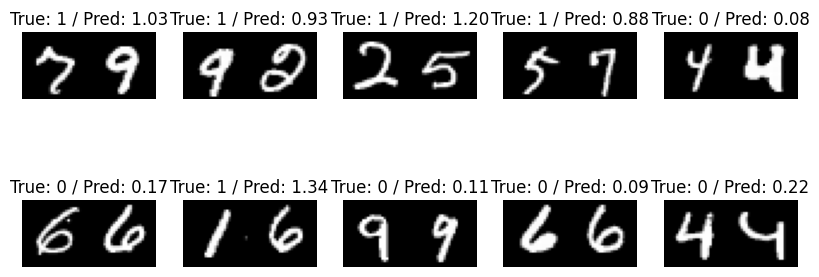

In [7]:
# 6. 결과 시각화
def plot_results(pairs, labels, model):
    plt.figure(figsize=(10, 4))
    for i in range(10):
        idx = np.random.randint(0, len(labels))
        pair = pairs[idx]
        label = labels[idx]
        pred = model.predict([np.expand_dims(pair[0], 0), np.expand_dims(pair[1], 0)])

        plt.subplot(2, 5, i+1)
        plt.imshow(np.hstack([pair[0].squeeze(), pair[1].squeeze()]), cmap='gray')
        plt.title(f"True: {int(label)} / Pred: {float(pred):.2f}")
        plt.axis('off')
    plt.show()

plot_results(pairs_test, labels_test, siamese_network)